In [7]:
# start add noise to the image
# what is the relation between error in m vs the noise level applied
# pixel noise vs shape noise (level of 0.2)

# read Dodelson: 1. overview, section 2,4, read section 6,7,8 + magnefication, possibly 9

In [8]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("/global/cfs/projectdirs/des/zhou/lsst_shear/shape-measurement-tutorials/src")


from utils import get_moments, get_elipticity, get_x_y
import galsim, ngmix

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
#The implementation of shape noise is questionable.

import ngmix
import numpy as np


def sim_func(*, g1, g2, seed, psf_fwhm, pixel_noise_std, size_noise_std=0,shape_noise_std=0):
    # this is an RNG you can use to draw random numbers as needed
    # always use this RNG and not np.random directly
    # doing this makes sure the code is reproducible
    
    rng = np.random.RandomState(seed=seed)

    size_nse = rng.normal(loc=0,scale=size_noise_std)
    # make an Exponential object in galsim with a half light radius of 0.5
    gal = galsim.Exponential(half_light_radius=0.5+size_nse)
    
    g1_noise = rng.normal(loc=0,scale=shape_noise_std)
    g2_noise = rng.normal(loc=0,scale=shape_noise_std)

    gal = gal.shear(g1=g1_noise, g2=g2_noise)

    # make a Gaussian object in galsim with a fwhm of `psf_fwhm`
    psf = galsim.Gaussian(fwhm=psf_fwhm)

    # apply the input shear `g1`, `g2` to the galaxy `gal`
    
    ### draw shear randomly scale=0.3 for shear 
    sheared_gal = gal.shear(g1=g1, g2=g2)

    # here we are going to apply a random shift to the object's center
    dx, dy = 2.0 * (rng.uniform(size=2) - 0.5) * 0.2
    sheared_gal = sheared_gal.shift(dx, dy)

    # convolve the sheared galaxy with the psf
    obj = galsim.Convolve(sheared_gal, psf)

    # render the object and the PSF on odd sized images of 53 pixels on a side with
    # a pixel scale of 0.2
    obj_im = obj.drawImage(scale=0.2, nx=53, ny=53)
    psf_im = psf.drawImage(scale=0.2, nx=53, ny=53)

    # now we are going to add noise to the object image and setup the ngmix data
    cen = (53 - 1) / 2
    nse_sd = pixel_noise_std
    nse = rng.normal(size=obj_im.array.shape, scale=nse_sd)
    nse_im = rng.normal(size=obj_im.array.shape, scale=nse_sd)
    
    jac = ngmix.jacobian.DiagonalJacobian(scale=0.2,
                                          row=cen + dy / 0.2,
                                          col=cen + dx / 0.2)
    psf_jac = ngmix.jacobian.DiagonalJacobian(scale=0.2, row=cen, col=cen)

    # Transformation between pixel and tangent uv coordinate. It has off diag terms if CCD is rotated.
    # in real data we care about off diag terms 

    # we have to add a little noise to the PSf to make things stable
    target_psf_s2n = 500.0
    target_psf_noise = np.sqrt(np.sum(psf_im.array**2)) / target_psf_s2n

    psf_obs = ngmix.Observation(
        image=psf_im.array,
        weight=np.ones_like(psf_im.array) / target_psf_noise**2,
        jacobian=psf_jac,
    )

    # here we build the final observation
    obj_obs = ngmix.Observation(
        image=obj_im.array + nse,
        noise=nse_im,
        weight=np.ones_like(nse_im) / nse_sd**2,
        jacobian=psf_jac,
        bmask=np.zeros_like(nse_im, dtype=np.int32),
        ormask=np.zeros_like(nse_im, dtype=np.int32),
        psf=psf_obs,
    )

    return obj_obs

In [10]:
obs_list_pixel_noise = []
obs_list_size_noise = []
obs_list_shape_noise = []

pixel_noise_std_range = 10**np.linspace(-8,-3,10)
size_noise_std_range = 10**np.linspace(-8,-1,10)
shape_noise_std_range = 10**np.linspace(-8,-1,10)

In [11]:
print(pixel_noise_std_range)
print(shape_noise_std_range)
print(size_noise_std_range)

[1.00000000e-08 3.59381366e-08 1.29154967e-07 4.64158883e-07
 1.66810054e-06 5.99484250e-06 2.15443469e-05 7.74263683e-05
 2.78255940e-04 1.00000000e-03]
[1.00000000e-08 5.99484250e-08 3.59381366e-07 2.15443469e-06
 1.29154967e-05 7.74263683e-05 4.64158883e-04 2.78255940e-03
 1.66810054e-02 1.00000000e-01]
[1.00000000e-08 5.99484250e-08 3.59381366e-07 2.15443469e-06
 1.29154967e-05 7.74263683e-05 4.64158883e-04 2.78255940e-03
 1.66810054e-02 1.00000000e-01]


In [12]:
# do your work here!
import mdet_meas_tools as mmt

In [24]:
pixel_noise_std_list = []
for pixel_noise_std_ in pixel_noise_std_range:
    pdata,mdata, m, msd, c, csd  = mmt.run_mdet_sims(sim_func=sim_func,sim_kwargs={'psf_fwhm':0.8, 'pixel_noise_std':pixel_noise_std_,'size_noise_std':0,'shape_noise_std':0},seed=123,n_sims=10)
    pixel_noise_std_list.append((msd,csd))
    res = mmt.estimate_m_and_c(pdata,mdata)

    # of sims: 10
    noise cancel m   :  0.377995 +/-  0.000779 [1e-3, 3-sigma]
    noise cancel c   : -0.004410 +/-  0.018099 [1e-5, 3-sigma]


    # of sims: 10
    noise cancel m   :  0.376853 +/-  0.002572 [1e-3, 3-sigma]
    noise cancel c   : -0.016151 +/-  0.064995 [1e-5, 3-sigma]


    # of sims: 10
    noise cancel m   :  0.372746 +/-  0.009050 [1e-3, 3-sigma]
    noise cancel c   : -0.058350 +/-  0.233557 [1e-5, 3-sigma]


    # of sims: 10
    noise cancel m   :  0.358062 +/-  0.032346 [1e-3, 3-sigma]
    noise cancel c   : -0.210011 +/-  0.839300 [1e-5, 3-sigma]


    # of sims: 10
    noise cancel m   :  0.304612 +/-  0.115897 [1e-3, 3-sigma]
    noise cancel c   : -0.756208 +/-  3.016469 [1e-5, 3-sigma]


    # of sims: 10
    noise cancel m   :  0.116437 +/-  0.416965 [1e-3, 3-sigma]
    noise cancel c   : -2.703230 +/-  10.847306 [1e-5, 3-sigma]


    # of sims: 10
    noise cancel m   : -0.551468 +/-  1.494267 [1e-3, 3-sigma]
    noise cancel c   : -9.477062 +/-  39.097457 [1e-5, 3-sigma]


    # of sims: 10
    noise cancel m   : -2.993687 +/-  5.334121 [1e-3, 3-sigma]
    noise cancel c   : -32.551783 +/-  141.458587 [1e-5, 3-sigma]


    # of sims: 10
    noise cancel m   : -11.453061 +/-  17.982694 [1e-3, 3-sigma]
    noise cancel c   : -107.986206 +/-  517.096891 [1e-5, 3-sigma]


    # of sims: 10
    noise cancel m   : -32.528796 +/-  65.944489 [1e-3, 3-sigma]
    noise cancel c   : -400.408593 +/-  1918.237212 [1e-5, 3-sigma]


In [42]:
size_noise_std_list = []
for size_noise_std_ in size_noise_std_range:
    print(f"{size_noise_std_=}")
    pdata,mdata, m, msd, c, csd  = mmt.run_mdet_sims(sim_func=sim_func,sim_kwargs={'psf_fwhm':0.8, 'pixel_noise_std':1e-5,'size_noise_std':size_noise_std_,'shape_noise_std':0},seed=123,n_sims=10)
    size_noise_std_list.append((msd,csd))
    res = mmt.estimate_m_and_c(pdata,mdata)

size_noise_std_=1e-08


    # of sims: 10
    noise cancel m   : -0.066880 +/-  0.694010 [1e-3, 3-sigma]
    noise cancel c   : -4.478950 +/-  18.102418 [1e-5, 3-sigma]


size_noise_std_=5.99484250318941e-08


    # of sims: 10
    noise cancel m   : -0.066433 +/-  0.694168 [1e-3, 3-sigma]
    noise cancel c   : -4.479207 +/-  18.102441 [1e-5, 3-sigma]


size_noise_std_=3.5938136638046254e-07


    # of sims: 10
    noise cancel m   : -0.066714 +/-  0.693739 [1e-3, 3-sigma]
    noise cancel c   : -4.479037 +/-  18.102460 [1e-5, 3-sigma]


size_noise_std_=2.1544346900318865e-06


    # of sims: 10
    noise cancel m   : -0.067424 +/-  0.694223 [1e-3, 3-sigma]
    noise cancel c   : -4.479002 +/-  18.102258 [1e-5, 3-sigma]


size_noise_std_=1.2915496650148827e-05


    # of sims: 10
    noise cancel m   : -0.066790 +/-  0.694051 [1e-3, 3-sigma]
    noise cancel c   : -4.479683 +/-  18.101122 [1e-5, 3-sigma]


size_noise_std_=7.742636826811278e-05


    # of sims: 10
    noise cancel m   : -0.066081 +/-  0.694539 [1e-3, 3-sigma]
    noise cancel c   : -4.480087 +/-  18.100542 [1e-5, 3-sigma]


size_noise_std_=0.0004641588833612782


    # of sims: 10
    noise cancel m   : -0.063112 +/-  0.695699 [1e-3, 3-sigma]
    noise cancel c   : -4.479951 +/-  18.099796 [1e-5, 3-sigma]


size_noise_std_=0.0027825594022071257


    # of sims: 10
    noise cancel m   : -0.057135 +/-  0.697036 [1e-3, 3-sigma]
    noise cancel c   : -4.490168 +/-  18.099489 [1e-5, 3-sigma]


size_noise_std_=0.016681005372000592


    # of sims: 10
    noise cancel m   : -0.069916 +/-  0.689822 [1e-3, 3-sigma]
    noise cancel c   : -4.560628 +/-  18.113747 [1e-5, 3-sigma]


size_noise_std_=0.1


    # of sims: 10
    noise cancel m   : -0.091837 +/-  0.697475 [1e-3, 3-sigma]
    noise cancel c   : -5.148925 +/-  18.894785 [1e-5, 3-sigma]


In [25]:
shape_noise_std_list = []
for shape_noise_std_ in shape_noise_std_range:
    print(f"{shape_noise_std_=}")
    pdata,mdata, m, msd, c, csd  = mmt.run_mdet_sims(sim_func=sim_func,sim_kwargs={'psf_fwhm':0.8, 'pixel_noise_std':1e-5,'shape_noise_std':shape_noise_std_},seed=123,n_sims=10)
    shape_noise_std_list.append((msd,csd))
    res = mmt.estimate_m_and_c(pdata,mdata)

shape_noise_std_=1e-08


    # of sims: 10
    noise cancel m   : -0.066456 +/-  0.694203 [1e-3, 3-sigma]
    noise cancel c   : -4.479203 +/-  18.102340 [1e-5, 3-sigma]


shape_noise_std_=5.99484250318941e-08


    # of sims: 10
    noise cancel m   : -0.066937 +/-  0.694375 [1e-3, 3-sigma]
    noise cancel c   : -4.481837 +/-  18.103583 [1e-5, 3-sigma]


shape_noise_std_=3.5938136638046254e-07


    # of sims: 10
    noise cancel m   : -0.067078 +/-  0.694120 [1e-3, 3-sigma]
    noise cancel c   : -4.506420 +/-  18.112027 [1e-5, 3-sigma]


shape_noise_std_=2.1544346900318865e-06


    # of sims: 10
    noise cancel m   : -0.066843 +/-  0.694035 [1e-3, 3-sigma]
    noise cancel c   : -4.643194 +/-  18.158055 [1e-5, 3-sigma]


shape_noise_std_=1.2915496650148827e-05


    # of sims: 10
    noise cancel m   : -0.066948 +/-  0.693810 [1e-3, 3-sigma]
    noise cancel c   : -5.465655 +/-  18.444889 [1e-5, 3-sigma]


shape_noise_std_=7.742636826811278e-05


    # of sims: 10
    noise cancel m   : -0.066988 +/-  0.693835 [1e-3, 3-sigma]
    noise cancel c   : -10.391177 +/-  20.488108 [1e-5, 3-sigma]


shape_noise_std_=0.0004641588833612782


    # of sims: 10
    noise cancel m   : -0.066973 +/-  0.692413 [1e-3, 3-sigma]
    noise cancel c   : -39.921540 +/-  38.513770 [1e-5, 3-sigma]


shape_noise_std_=0.0027825594022071257


    # of sims: 10
    noise cancel m   : -0.065158 +/-  0.693927 [1e-3, 3-sigma]
    noise cancel c   : -216.941499 +/-  170.117676 [1e-5, 3-sigma]


shape_noise_std_=0.016681005372000592


    # of sims: 10
    noise cancel m   : -0.059465 +/-  0.692775 [1e-3, 3-sigma]
    noise cancel c   : -1278.327617 +/-  975.640607 [1e-5, 3-sigma]


shape_noise_std_=0.1


    # of sims: 10
    noise cancel m   : -0.050394 +/-  0.682323 [1e-3, 3-sigma]
    noise cancel c   : -7673.448130 +/-  5885.538543 [1e-5, 3-sigma]


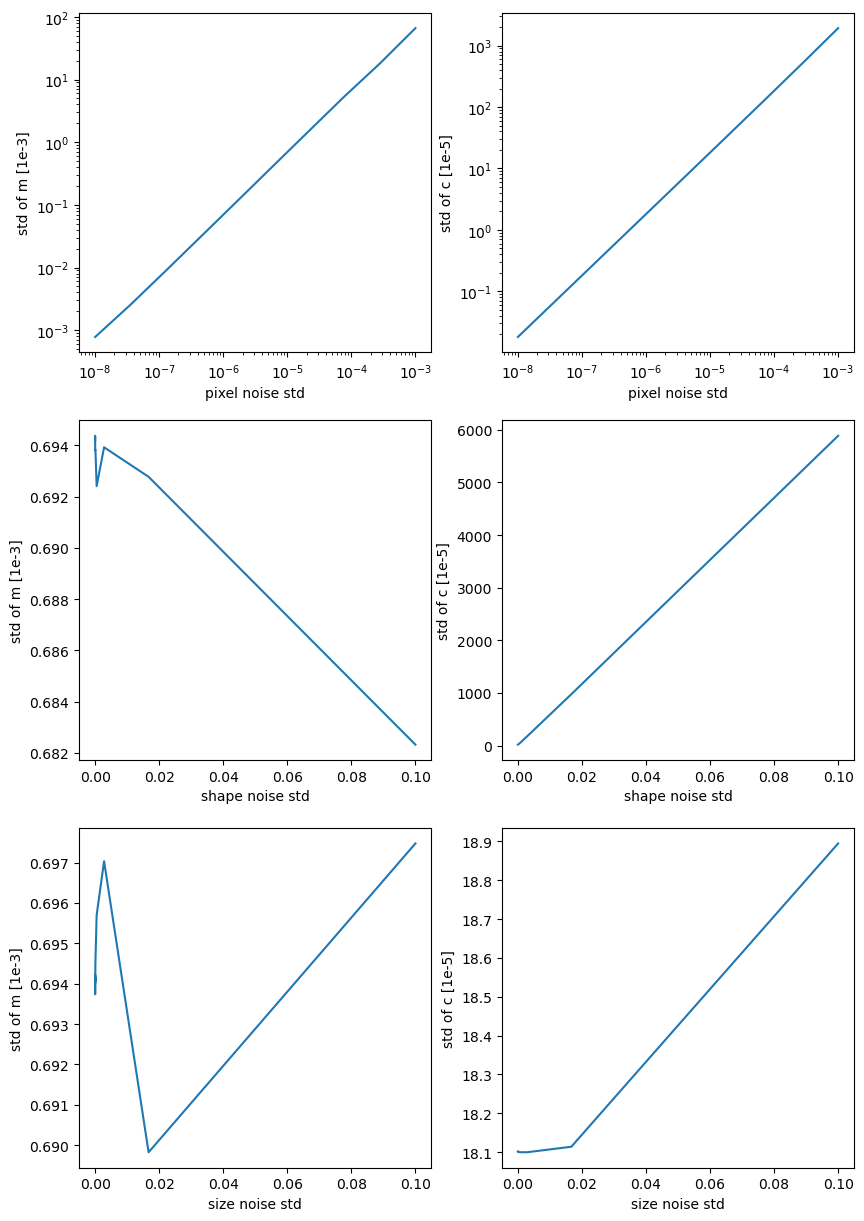

In [43]:
import matplotlib.pyplot as plt

def plot_m_and_c(pixel_noise_std_list,shape_noise_std_list,size_noise_std_list):

    plt.figure(figsize=(10,15))

    plt.subplot(3,2,1)
    plt.plot(pixel_noise_std_range,[i[0] for i in pixel_noise_std_list])
    plt.xlabel('pixel noise std')
    plt.ylabel('std of m [1e-3]')
    plt.xscale('log')
    plt.yscale('log')
    plt.subplot(3,2,2)
    plt.plot(pixel_noise_std_range,[i[1] for i in pixel_noise_std_list])
    plt.xlabel('pixel noise std')
    plt.xscale('log')
    plt.yscale('log')
    plt.ylabel('std of c [1e-5]')

    plt.subplot(3,2,3)
    plt.plot(shape_noise_std_range,[i[0] for i in shape_noise_std_list])
    plt.xlabel('shape noise std')
    plt.ylabel('std of m [1e-3]')
    plt.subplot(3,2,4)
    plt.plot(shape_noise_std_range,[i[1] for i in shape_noise_std_list])
    plt.xlabel('shape noise std')
    plt.ylabel('std of c [1e-5]')
    
    
    plt.subplot(3,2,5)
    plt.plot(size_noise_std_range,[i[0] for i in size_noise_std_list])
    plt.xlabel('size noise std')
    plt.ylabel('std of m [1e-3]')
    plt.subplot(3,2,6)
    plt.plot(size_noise_std_range,[i[1] for i in size_noise_std_list])
    plt.xlabel('size noise std')
    plt.ylabel('std of c [1e-5]')
    plt.show()


plot_m_and_c(pixel_noise_std_list,shape_noise_std_list,size_noise_std_list)